In [1]:
%matplotlib inline

In [2]:
import Constants as C
from MakeModels import *
encoder = makeEncoder(C.batchSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

Using TensorFlow backend.


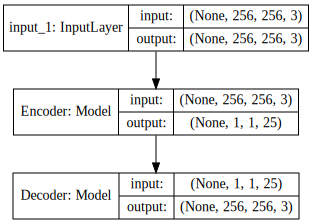

In [3]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(autoencoder,show_shapes=True).create(prog='dot', format='svg')))

Found 52850 images belonging to 1 classes.
Found 22650 images belonging to 1 classes.
(32, 256, 256, 3)


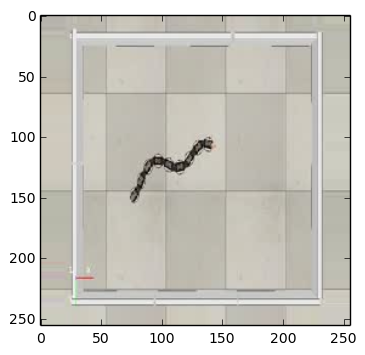

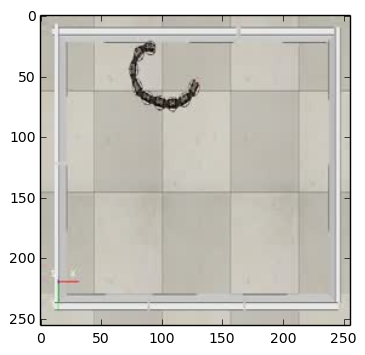

In [6]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import image

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/Training'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/Validation'

train_generator = train_datagen.flow_from_directory(
        trainPath,
        target_size=(C.imDim, C.imDim), shuffle=True,
        batch_size=C.batchSz)

validation_generator = val_datagen.flow_from_directory(
        valPath,
        target_size=(C.imDim, C.imDim),
        batch_size=C.batchSz)

X_batch,y_batch = train_generator.next()
# X_batch = X_batch.transpose(0,2,3,1)
print X_batch.shape
plt.figure()
plt.imshow(X_batch[0,:])
plt.figure()
plt.imshow(X_batch[3,:])

# model.fit_generator(
#         train_generator,
#         samples_per_epoch=2000,
#         nb_epoch=50,
#         validation_data=validation_generator,
#         nb_val_samples=800)

In [7]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb


numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 100

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

def trainGenerator():
    files = os.listdir(trainPath)
    files = files[:numBatchesPerEpoch*C.batchSz]
    while True:
        res = np.zeros(shape=(C.batchSz,C.imDim,C.imDim,3))
        for i in range(numBatchesPerEpoch):
            for j in range(C.batchSz):
                res[j,:] = plt.imread(trainPath+files[i*C.batchSz+j]).astype('float32')/255.0
            yield (res,res)
        
def valGenerator():  
    files = os.listdir(valPath)
    files = files[:nValBatches*C.batchSz]
    res = np.zeros(shape=(C.batchSz,C.imDim,C.imDim,3))
    while True:
        for i in range(nValBatches):
            for j in range(C.batchSz):
                res[j,:] = plt.imread(valPath+files[i*C.batchSz+j]).astype('float32')/255.0
            yield (res,res)

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


lr = 0.1
print "Learning rate=" + str(lr)
print "Compiling model"
autoencoder.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = autoencoder.fit_generator(generator=trainGenerator(),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=valGenerator(),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/Model.h5'),
                                               ReduceLROnPlateau(factor=0.2,patience=2)]
                                   )

(32, 256, 256, 3)


/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


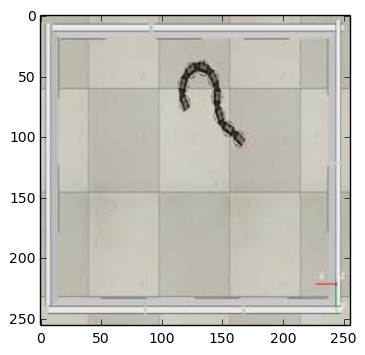

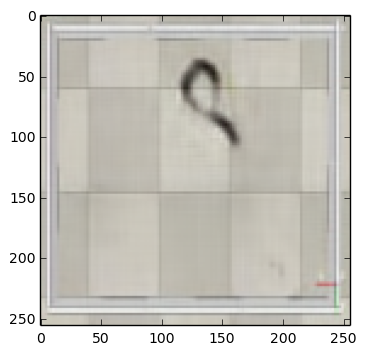

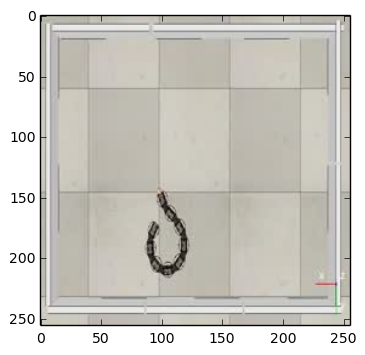

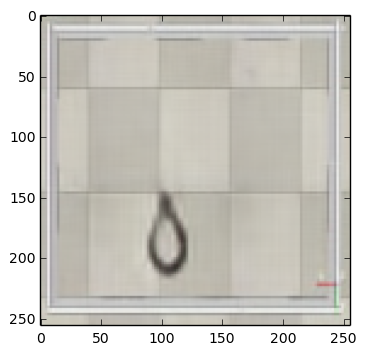

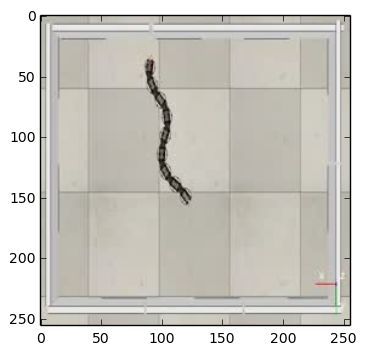

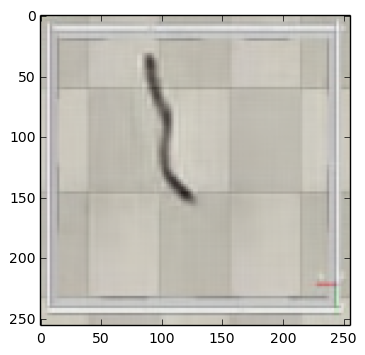

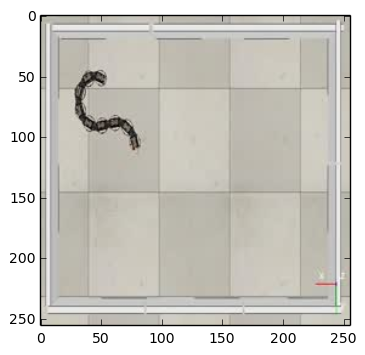

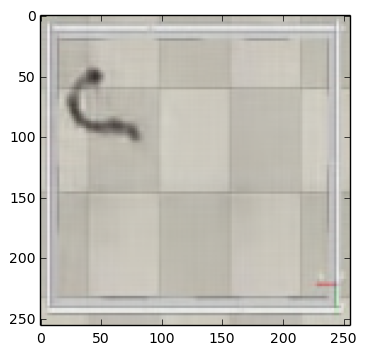

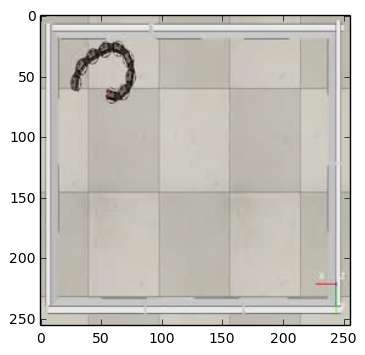

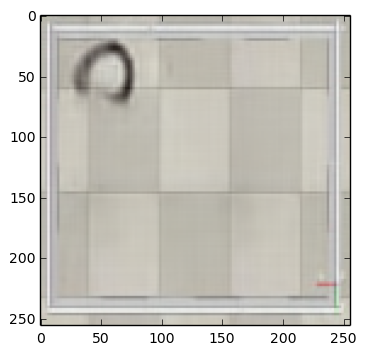

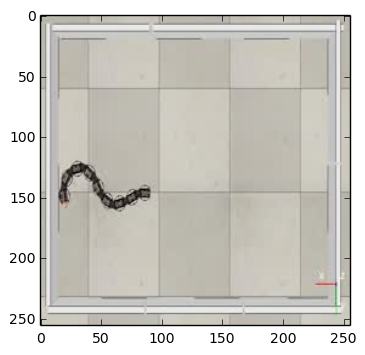

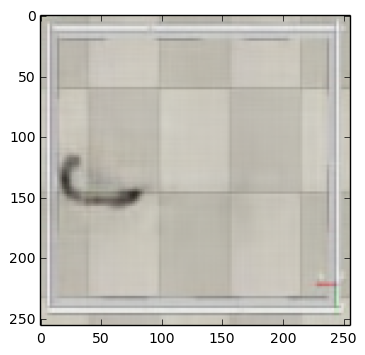

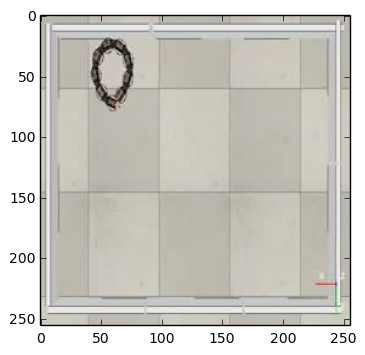

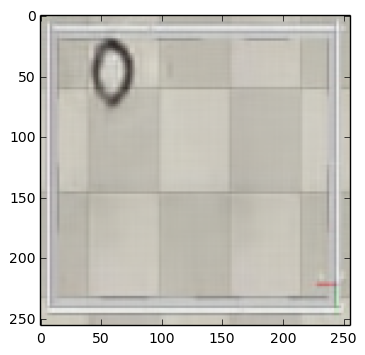

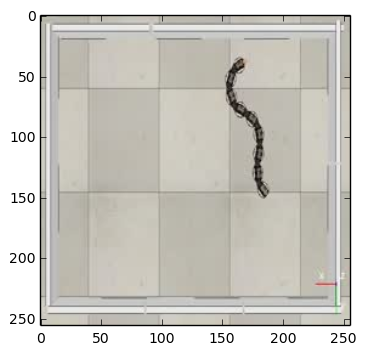

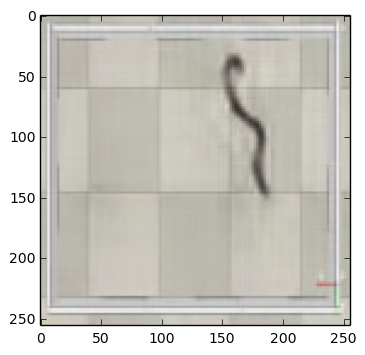

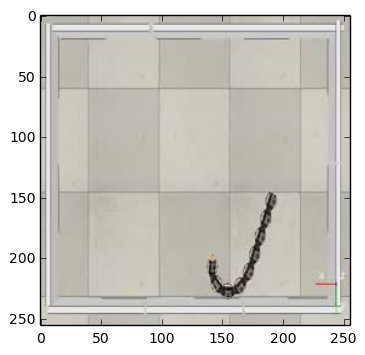

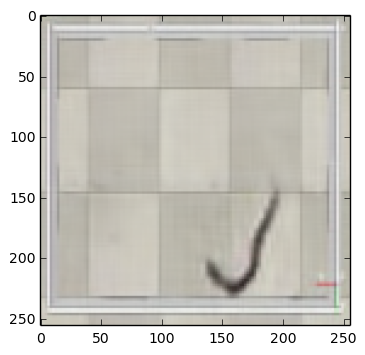

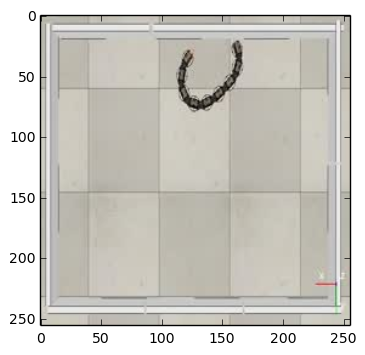

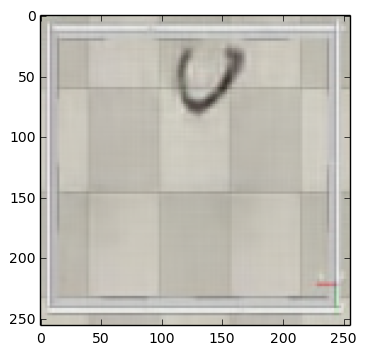

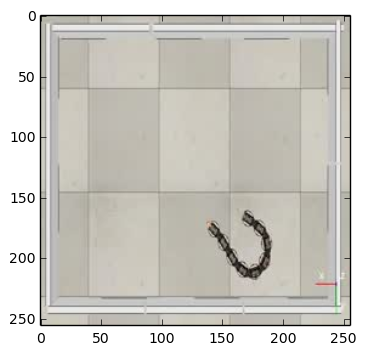

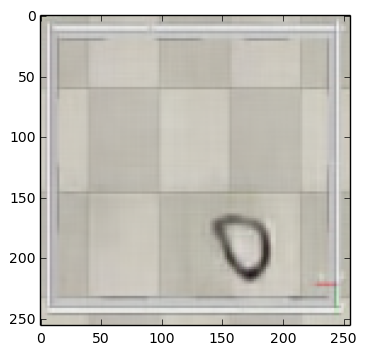

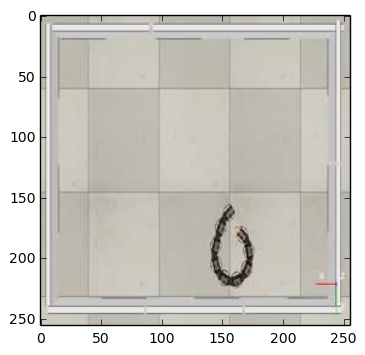

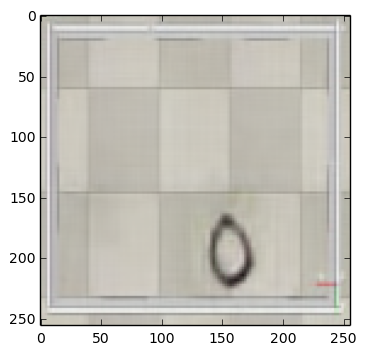

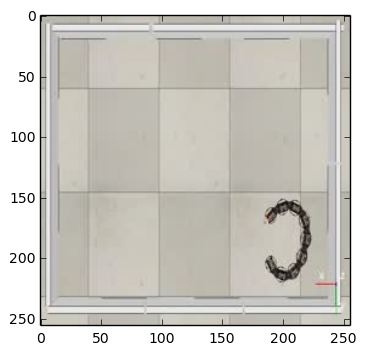

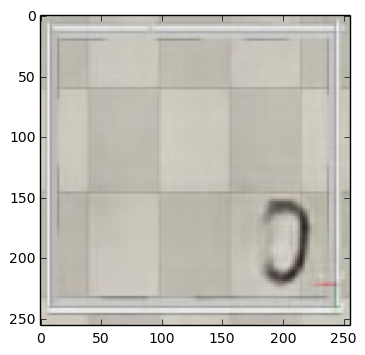

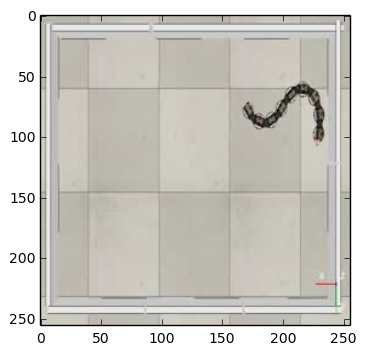

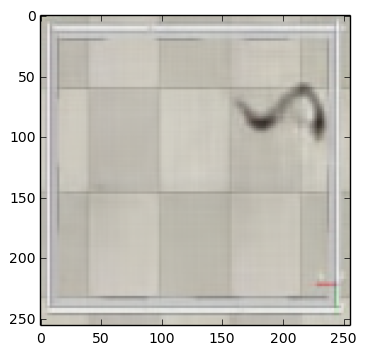

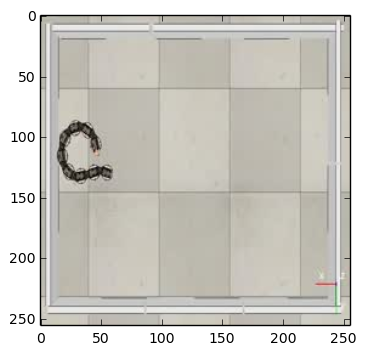

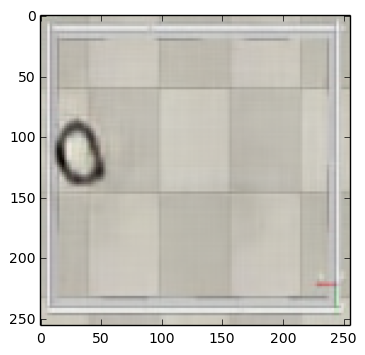

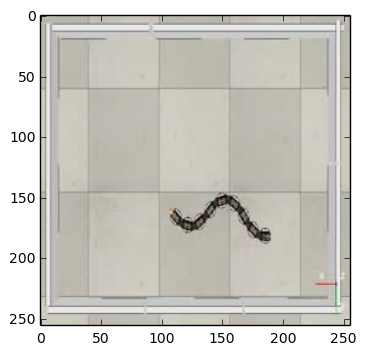

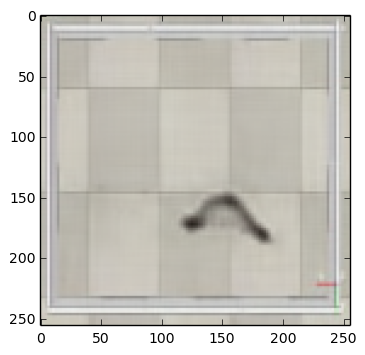

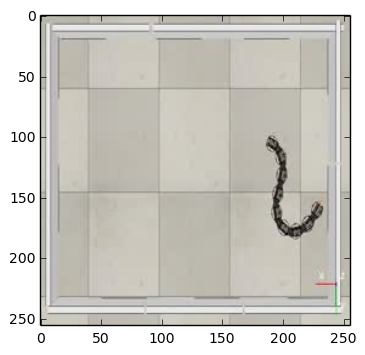

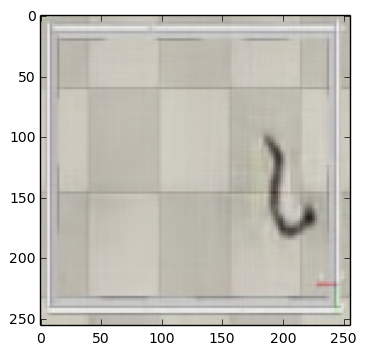

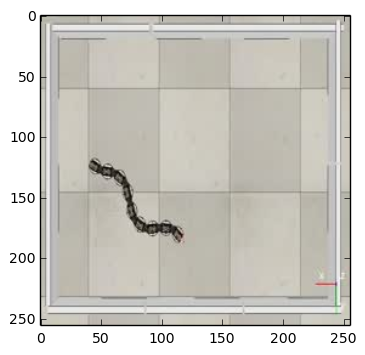

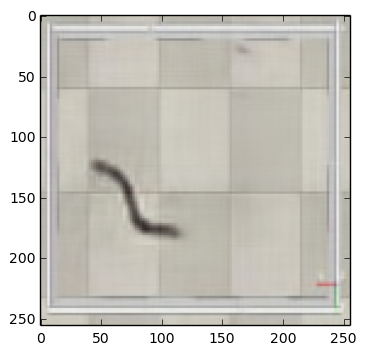

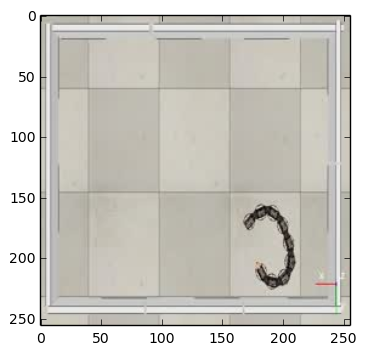

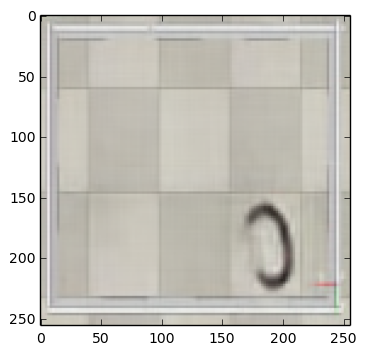

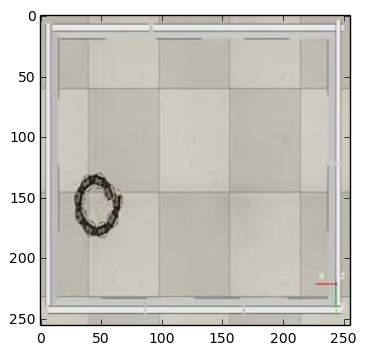

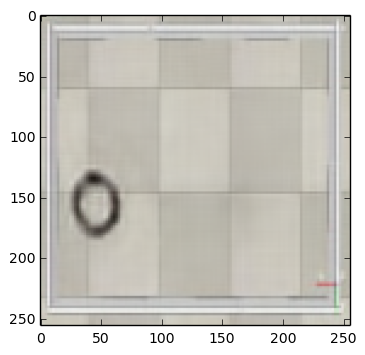

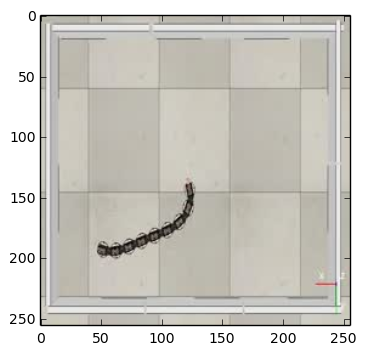

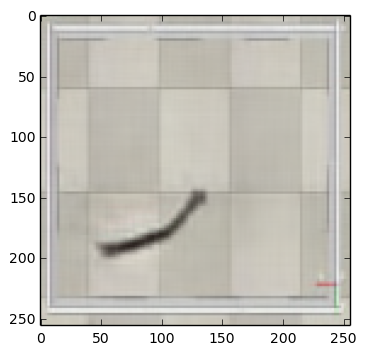

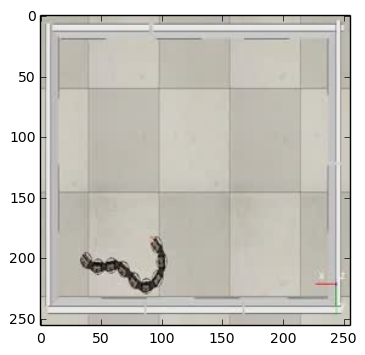

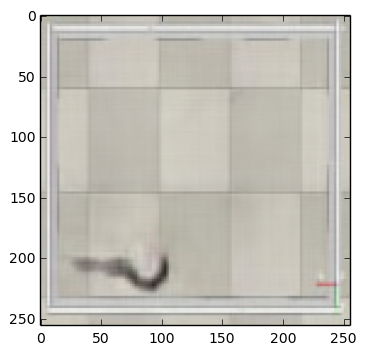

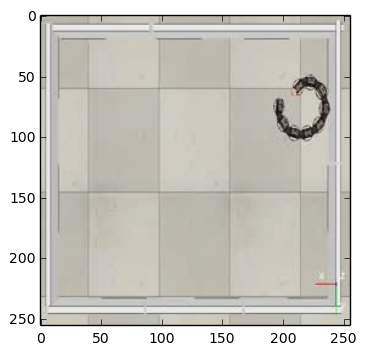

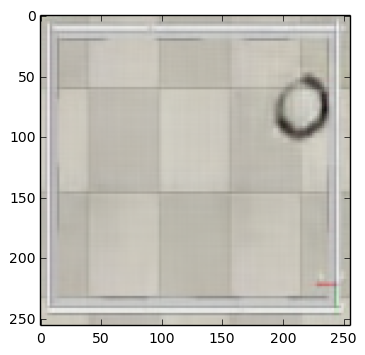

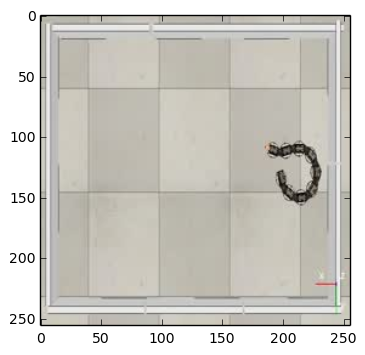

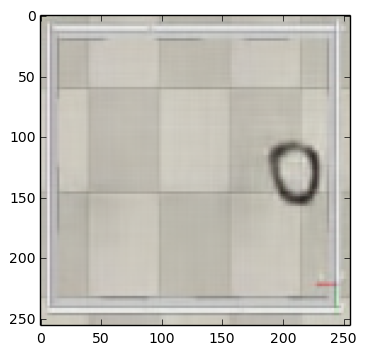

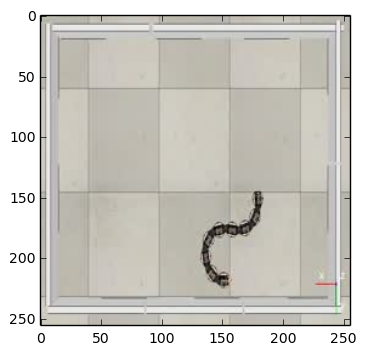

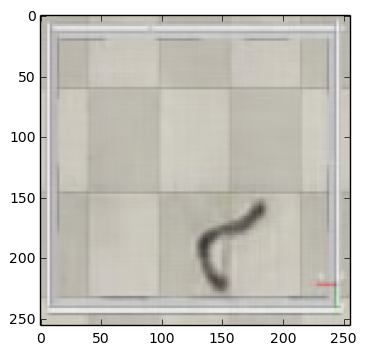

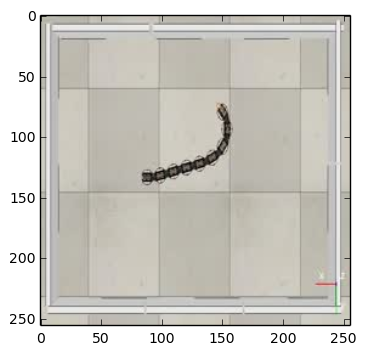

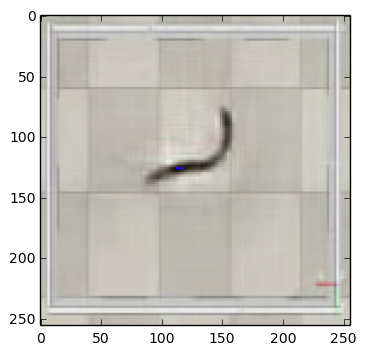

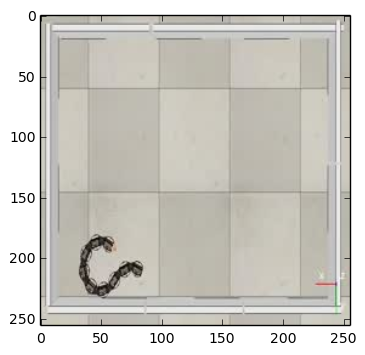

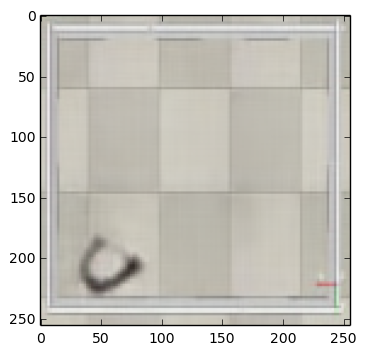

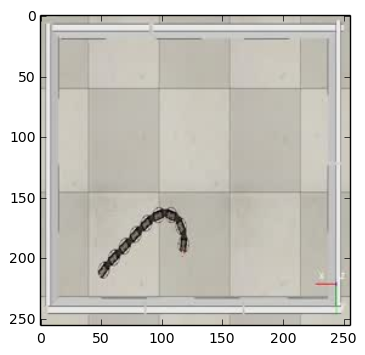

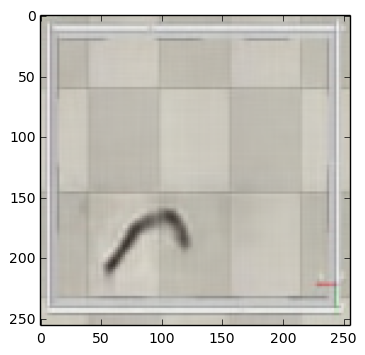

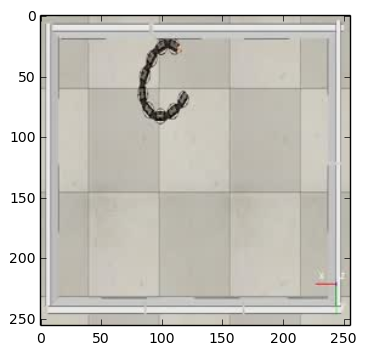

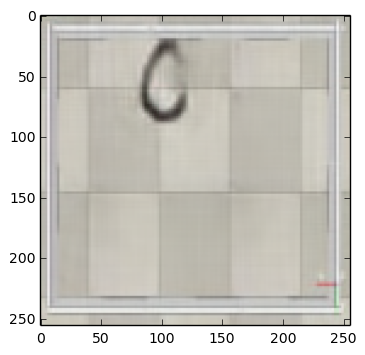

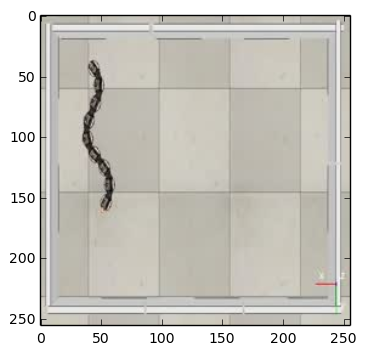

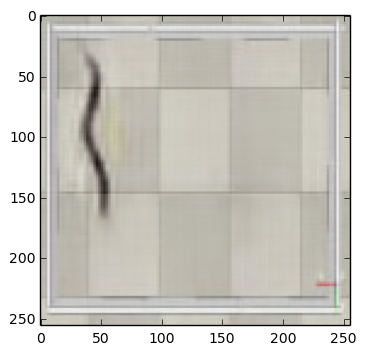

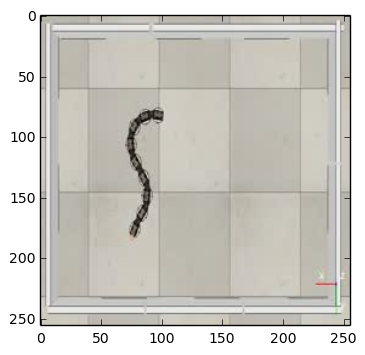

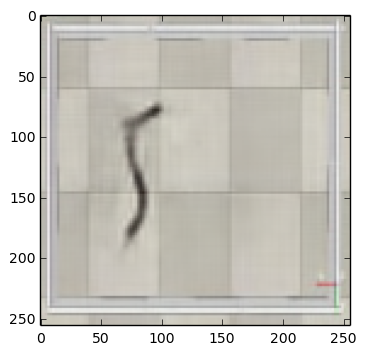

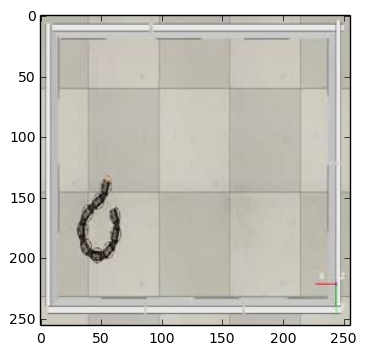

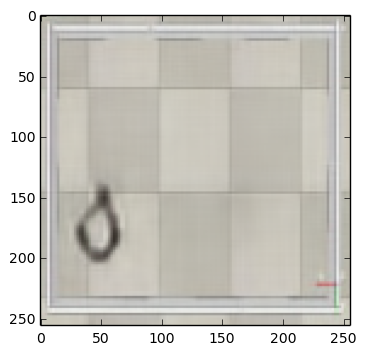

In [8]:
autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)
im_in = trainGenerator().next()
im_in = im_in[0]
im_out = autoencoder.predict_on_batch(im_in)
print im_out.shape

for i in range(C.batchSz):
    plt.figure()
    plt.imshow(im_in[i,:])
    plt.figure()
    plt.imshow(im_out[i,:])

In [ ]:
encoded = encoder.predict_on_batch(im_in)
decoded = decoder.predict_on_batch(encoded)
for i in range(C.batchSz):
    plt.figure()
    plt.imshow(im_in[i,:])
    plt.figure()
    plt.imshow(im_out[i,:])

In [ ]:
from keras.layers import merge, Convolution2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

# first, define the vision modules
digit_input = Input(shape=(1, 25, 25),name="Input1")
x = Convolution2D(64, 3, 3)(digit_input)
x = Convolution2D(64, 3, 3)(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)

vision_model = Model(digit_input, out,name="Vision")

# then define the tell-digits-apart model
digit_a = Input(shape=(1, 27, 27),name="Input2")
digit_b = Input(shape=(1, 27, 27),name="Input3")

# the vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = merge([out_a, out_b], mode='concat')
out = Dense(1, activation='sigmoid')(concatenated)

classification_model = Model([digit_a, digit_b], out)

from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(classification_model).create(prog='dot', format='svg')))

classification_model.summary()

In [ ]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb



numEpochs = 100
numBatchesPerEpoch = 2
nVal = 200

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

def smallTrainGenerator():
    files = os.listdir(trainPath)
    files = files[:numBatchesPerEpoch*C.batchSz]
    while True:
        res = np.zeros(shape=(C.batchSz,C.imDim,C.imDim,3))
        for i in range(numBatchesPerEpoch):
            for j in range(C.batchSz):
                res[j,:] = plt.imread(trainPath+files[i*C.batchSz+j])
            yield (res,res)
        
def smallValGenerator():  
    files = os.listdir(valPath)
    files = files[:nVal]
    res = np.empty(shape=(0,C.imDim,C.imDim,3))
    for i in range(nVal):
        im = np.expand_dims(plt.imread(valPath+files[i]),axis=0)
        res = np.concatenate((res,im))
    yield (res,res)
            

# def trainModel(model,trainGenerator,validationGenarator):
#     loss = []
#     validation = []
    
#     Xtrain = np.empty(shape=(0,C.imDim,C.imDim, 3))
#     for i in range(numBatchesPerEpoch):
#         train,_ = trainGenerator.next()
#         Xtrain = np.concatenate((Xtrain,train.transpose(0,2,3,1)))
        
#     Xval = np.empty(shape=(0,C.imDim,C.imDim,3))
#     for i in range(int(round(nVal/C.batchSz)):
#         val,_ = validationGenarator.next()
#         Xval = np.concatenate((Xval,val.transpose(0,2,3,1)))
        
#     for i in range(numEpochs):
#         print "Epoch %d of %d" (i+1,numEpochs)
#         for j in tqdm(range(numBatchesPerEpoch)):
#             Xbatch = Xtrain[j*C.batchSz:(j+1):C.batchSz,:]
#             loss.append(model.train_on_batch(Xbatch,Xbatch))
#         Xbatch, _ = validation_generator.flow()
#         validation.append(model.test_on_batch(Xval,Xval))
#         print "Epoch %d, loss = %f, val = %f" (i+1,loss[-1],validation[-1])
        
#     return [loss, validation]

In [ ]:
val_data_gen = smallValGenerator()
val_data = val_data_gen.next()

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard

histories = []
lrs = np.sort(10**random.uniform(-1,2,size=10))
for lr in lrs:
    print "Learning rate=" + str(lr)
    print "Compiling model"
    autoencoder.compile(optimizer=Adam(lr=lr),loss='mse')
    print "Done compiling model"
    
    
#     [loss,val] = trainModel(numEpochs=numEpochs,
#                             numBatchesPerEpoch=numBatchesPerEpoch,
#                             nVal=nVal,
#                             model=autoencoder,
#                             trainGenerator=train_generator,
#                             validationGenarator=validation_generator)
    history = autoencoder.fit_generator(generator=smallTrainGenerator(),
                                        samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                        nb_epoch=numEpochs,
                                        validation_data=val_data,
                                        callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs')]
                                       )
    histories.append(history)

In [ ]:
# %load 'MakeModels.py'
from keras.layers import merge, Deconvolution2D, UpSampling2D, Convolution2D, MaxPooling2D, Input, Dense, Flatten, Merge, BatchNormalization, LeakyReLU, LSTM
from keras.models import Model
import os

nBottleneck = 25

imageInput = Input(shape=(C.imDim, C.imDim, 3))

nWindow = 1
lstmTimeSize = 32
positionInput = Input(shape=(2*nWindow,))
nHiddenLSTM = 64

def makeEncoder(C.batchSz):
    gC.batchSz = C.batchSz
    # first, define the encoder

    # C.imDim x C.imDim input
    x = Convolution2D(32, 4, 4, subsample=(2, 2), border_mode='same', dim_ordering='tf')(imageInput)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 128 x 128 input
    x = Convolution2D(32, 4, 4, subsample=(2, 2), border_mode='same', dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 64 x 64 input
    x = Convolution2D(32, 4, 4, subsample=(2, 2), border_mode='same', dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 32 x 32 input
    x = Convolution2D(64, 4, 4, subsample=(2, 2), border_mode='same', dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 16 x 16 input
    x = Convolution2D(128, 4, 4, subsample=(2, 2), border_mode='same', dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 8 x 8 input
    x = Convolution2D(128, 4, 4, subsample=(2, 2), border_mode='same', dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 4 x 4 input
    encodedFeatures = Convolution2D(nBottleneck, 4, 4, subsample=(1, 1), border_mode='valid', dim_ordering='tf')(x)

    encoder_model = Model(imageInput, encodedFeatures, name='Encoder')
    return encoder_model

def makeDecoder():
    # decoder_model 
    encoded_input = Input(shape=(1,1,nBottleneck))

    # 1,1,2000 input
    x = UpSampling2D(size=(4,4),dim_ordering='tf')(encoded_input)
    x = Convolution2D(128, 4, 4, subsample=(1, 1), border_mode='same', dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 4x4x512 input
    x = Convolution2D(128, 4, 4, subsample=(1, 1), border_mode='same', dim_ordering='tf')(x)
    x = UpSampling2D(size=(2,2),dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 8x8xC.imDim input
    x = Convolution2D(64, 4, 4, subsample=(1, 1), border_mode='same', dim_ordering='tf')(x)
    x = UpSampling2D(size=(2,2),dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 16x16xC.imDim input
    x = Convolution2D(64, 4, 4, subsample=(1, 1), border_mode='same', dim_ordering='tf')(x)
    x = UpSampling2D(size=(2,2),dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 32x32x128 input
    x = Convolution2D(64, 4, 4, subsample=(1, 1), border_mode='same', dim_ordering='tf')(x)
    x = UpSampling2D(size=(2,2),dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 64x64x64 input
    x = Convolution2D(32, 4, 4, subsample=(1, 1), border_mode='same', dim_ordering='tf')(x)
    x = UpSampling2D(size=(2,2),dim_ordering='tf')(x)
    x = BatchNormalization(mode=2)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 128x128x64 input
    x = Convolution2D(3, 4, 4, subsample=(1, 1), border_mode='same', dim_ordering='tf')(x)
    x = UpSampling2D(size=(2,2),dim_ordering='tf')(x)

    generator_model = Model(encoded_input,x,name="Decoder")
    return generator_model

def makeAutoencoder(encoder_model, generator_model):
    x = encoder_model(imageInput)
    x = generator_model(x)
    autoencoder = Model(imageInput, x)
    return autoencoder

def makePlainLSTM():
    x = K.expand_dims(position_input,axis=0)
    x = LSTM(nHiddenLSTM)(positionInput)
    x = Dense(round(nHiddenLSTM/2))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1)(x)
    plainLSTM = Model(positionInput,x)
    return plainLSTM

def makeImageLSTM(encoder):
    y = encoder(imageInput)
    x = Merge([positionInput,y],mode='concat')
    x = K.expand_dims(x,axis=0)
    x = LSTM(nHiddenLSTM)(x)
    x = Dense(round(nHiddenLSTM/2))(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1)(x)
    imageLSTM = Model(inputs=[positionInput,imageInput],x)
    return imageLSTM